In [1]:
using ResumableFunctions, ConcurrentSim, Plots, Random, Distributions

# Entanglement Switch

An entanglement swtich is a node in a quantum network that creates entanglement with
some end nodes, and then performs measurements on its entangled qubits to create
entanglement between the end nodes (a process we will refer to as "entanglement swapping",
slightly abusing terminology).
Creating and storing entanglement between the switch and end nodes requires a qubit,
and the switch only has a limited number of qubits.

We model the switch using a structure that tracks available qubits and entanglement.
Moreover, we track "entanglement tickets": we allow a process to claim such a ticket,
which gives it ownership of a particular entangled state.
This allows it to claim entanglement before the process is actually ready to consume it
through entanglement swapping.

We will simulate the dynamics of entanglement being consumed according to swapping
requests, which are made by the end nodes over the course of the simulation.
We give the switch fields to track how many requests are currently open and how many have
been fulfilled in total.

In [2]:
mutable struct EntanglementSwitch
    env::Environment
    qubits::Resource
    entanglements::Vector{Int}
    entanglement_tickets::Store{Int}
    num_open_requests::Int
    num_fulfilled_requests::Int
    """
    we use an inner constructor: you only need to provide the environment and the number
    of qubits when creating a new switch instance.
    """
    function EntanglementSwitch(env::Environment, num_qubits::Int)
        new(env, Resource(env, num_qubits, level=num_qubits), Int[],
            Store{Int}(env; capacity=num_qubits), 0, 0)
    end
end

We will have independent processes that create and consume entanglement, and will study
the emergent dynamics of the switch.
An entangler process continuously tries to claim qubits and use them to create
entanglement with one particular end node.
Trying to entangling a qubit with an end node takes one time step,
but it is hard and only succeeds with a small probability.
Therefore, the amount of time until success is geometrically distributed.

In [3]:
@resumable function entangler(env::Environment, switch::EntanglementSwitch,
        success_probability::Float64, end_node::Int)
    while true
        @yield get(switch.qubits, 1)
        duration = rand(Geometric(success_probability)) + 1
        @yield timeout(env, duration)
        #md println("$(now(env)): entanglement $end_node created")
        push!(switch.entanglements, end_node)
        put!(switch.entanglement_tickets, end_node)
        #md println("Entanglement: $(switch.entanglements)")
    end
end

entangler (generic function with 1 method)

A request fulfiller takes one specific swapping request and becomes resonsible for
fulfilling it. It claims entanglement tickets corresponding to the end nodes
that want to be entanglement, and performs the swap once all relevant tickets
are obtained.

In [4]:
@resumable function request_fulfiller(env::Environment, switch::EntanglementSwitch,
        request::Vector{Int}, max_wait_time)

    switch.num_open_requests += 1

    entanglement_tickets =
        [get(switch.entanglement_tickets, isequal(i)) for i in request]
    @yield AllOf(entanglement_tickets...)
    for end_node in request  # consume the entanglement it holds tickets for
        deleteat!(switch.entanglements,
            findfirst(isequal(end_node), switch.entanglements))
    end
    put!(switch.qubits, length(request)) # release the qubits that held the entangled states
    switch.num_open_requests -= 1 # log that we have successfully fulfilled the request
    switch.num_fulfilled_requests += 1
end

request_fulfiller (generic function with 1 method)

Finally, there we make a requester process that randomly generates and issues requests.

In [5]:
@resumable function requester(env::Environment, switch::EntanglementSwitch,
        num_end_nodes_total, num_end_nodes_per_request, request_rate, max_wait_time)
    distribution = Exponential(1 / request_rate)
    while true
        if switch.num_open_requests > 10000
            throw("Too many open requests at time $(now(env)), unstable system!")
        end
        @yield timeout(env, rand(distribution))
        request = randperm(num_end_nodes_total)[1:num_end_nodes_per_request]
        #md println("$(now(env)): new request $request")
        @process request_fulfiller(env, switch, request, max_wait_time)
    end
end

requester (generic function with 1 method)

Let's set up some parameters and run the simulation!

set up parameters

In [6]:
num_communication_qubits = 8
num_end_nodes = 3
request_rates = [0.05, 0.01]  # entanglement between 2, 3, ... end nodes
success_probabilities = [0.1, 0.1, 0.1]
max_wait_time = 100

100

initialize the simulation

In [7]:
sim = Simulation()
switch = EntanglementSwitch(sim, num_communication_qubits)
[@process requester(sim, switch, num_end_nodes, i + 1, request_rates[i], max_wait_time)
    for i in eachindex(request_rates)]
[@process entangler(sim, switch, success_probabilities[i], i) for i in 1:num_end_nodes]

3-element Vector{ConcurrentSim.Process}:
 ConcurrentSim.Process 5
 ConcurrentSim.Process 7
 ConcurrentSim.Process 9

run it!

In [8]:
open_reqs = []
fulfilled_reqs = []
ts = 1:10:10000
for t in ts
    run(sim, t)
    push!(open_reqs, switch.num_open_requests)
    push!(fulfilled_reqs, switch.num_fulfilled_requests)
end

Visualize how the number of open and fulfilled requests changes over time.

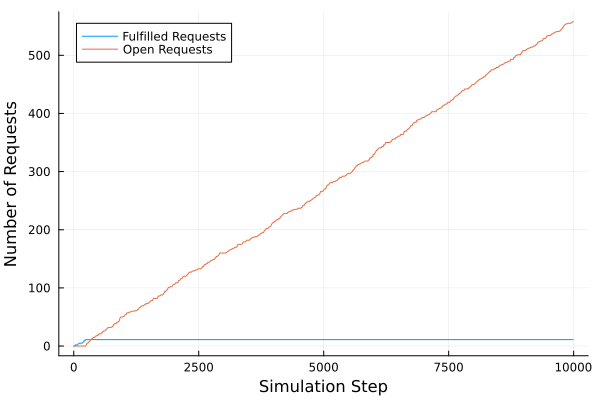

In [9]:
plot(ts, fulfilled_reqs, label="Fulfilled Requests", xlabel="Simulation Step",
    ylabel="Number of Requests")
plot!(ts, open_reqs, label="Open Requests", xlabel="Simulation Step")

What is going wrong?
Do you have ideas how to fix it?

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*